## Helper functions & imports

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.integrate
import scipy as sp
from scipy import integrate

def compare_fit(func, method: str="", caption: bool=True):
    """
    plots your fit function into the histograms
    x is your linspace of x values.
    fit_y is your array of y values.
    The "method" parameter is just to put it in the title of the plot
    Returns n, which is what plt_hist returns in an array: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    """

    fig,ax=plt.subplots(1, 4, figsize=(15,4), constrained_layout=True)
    x = np.linspace(0, 1, 1000)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    for k,i in enumerate(bins):
        n = ax[k].hist(s, i,color='purple', density=True) # By the time this func is called, s will be known.
        
        if caption:
            lambdas = func(n) # lambdas = [lambda1 , lambda2]
            textstr = '\n'.join((
            r'$\lambda_1=%.2f$' % (lambdas[0], ),
            r'$\lambda_2=%.2f$' % (lambdas[1], )))
            ax[k].text(0.6, 0.95, textstr, transform=ax[k].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        else:
            lambdas= func()
        ax[k].plot(x, f(x, lambdas[0], lambdas[1]), color='orange') # Plot the fit function
    fig.suptitle(f"Histograms of mixed data - {method}")
    plt.show()

bins = [5,10,50, 100] # Amount of bins used for the histograms. Given in the exercise.

# Our fit function that we use everywhere; a=lambda1, b=lambda2.
f = lambda x,a, b: 0.5*(a*np.exp(-a*x) + b*np.exp(-b*x))

## Generating data

In [147]:
#Generating the two random datasets of exponential distributions (lambda=10,lambda=50)
s1 = np.random.exponential((1/10),1000)
s2 = np.random.exponential((1/50),1000)
#mixing data sets
s = np.append(s1, s2)

## Method of Moments

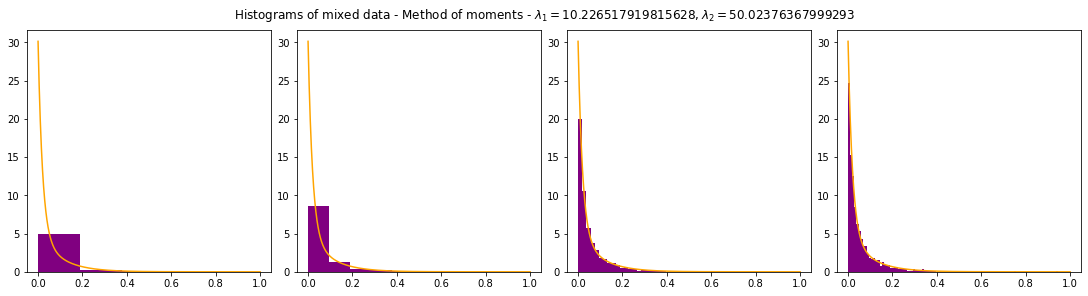

In [148]:
def k_moment(data, k=1):
    """
        This function returns the estimate of the kth moment of the data set.
    """
    n=len(data)
    sum=np.sum(data**k)
    return (1/n)*sum


x= np.linspace(0,1,100)
def fit_func():
    #We are trying to estimate two parameters so we only need 2 moments.
    (m1,m2)= (k_moment(s,1),k_moment(s,2))

    # Using the formulas we derived:
    lambda1=(m1+np.sqrt(0.5*m2-m1**2))**(-1)
    lambda2=(m1-np.sqrt(0.5*m2-m1**2))**(-1)

    return [lambda1,lambda2]

# Here we just wanna plot but the hist_values and bin_edges will be used later in the least squares method.
n = compare_fit(fit_func, f"Method of moments - $\lambda_1 = {fit_func()[0]}, \lambda_2 = {fit_func()[1]}$", caption=False)

## Method of Least Squares

The main ideas were taken from the lecturer's notebook, with approval of our TA. Though we did *not* copy paste. We wrote it ourselves.

### Helper functions

In [152]:
def bin_probability(params, f, bin_edges):
    """
    Gives you the probability associated with each bin given a fitting function (PDF) 
    by integration of the function over the bin.

    Arguments:
        params          (array-like)                The parameters that the fitting function f takes                     
        f               (function)                  The fitting function that we want to test the parameters on
        bin_edges       (array-like)                Array of bin edges as returned by plt.hist() or the numpy equivalent
    Returns:
        integral_value  (array-like)                Array with the probability of each bin.

    """

    int_f = lambda x: f(x,params[0], params[1]) # Evaluates PDF for integration purposes

    integral_val = np.empty(0)

    for a,b in np.nditer([bin_edges[:-1],bin_edges[1:]]):   # a and b will be the integration bounds.
        val = scipy.integrate.quad(int_f,a,b)
        integral_val = np.append(integral_val,val)
    return integral_val

def res(params, f, bin_edges, hist, yerr, integration: bool=False):
    """

    Calculates the chi squared value of certain parameters for fit function s on histogram hist.

    Arguments:
            params      (array-like)                The parameters that the fitting function f takes                     
            f           (function)                  The fitting function that we want to test the parameters on
            bin_edges   (array-like)                Array of bin edges as returned by plt.hist() or the numpy equivalent
            hist        (array-like)                Array of heights of the histogram
            yerr        (array-like)                Dataset containing the corresponding error of every value.
            integration (boolean)                   Whether to use integration for bin probabilities. Defaults to false.
    Returns:
            result  (float)                         The chi squared value of the parameters on function f fitted over the histogram.

    """
    result = 0
    cbins = (bin_edges[:-1]+bin_edges[1:])/2   # calculate centres of the bins
    bin_width = bin_edges[1:] - bin_edges[:-1]
    
    # Either integrate over the bins or just evaluate the fit function * bin width at every bin.
    # Prediction here is for the total probability between the two bin edges.
    prediction = bin_probability(params, f, bin_edges) if integration else bin_width*f(cbins, params[0], params[1]) 

    for i in range(len(prediction)):
        result += ((bin_width*hist[i] - prediction[i])**2/(yerr[i])**2)
    return result


# x = np.linspace(0,1, len(hist_values[i_nonzero]))
starting_values = (10,50)


### Without statistical error

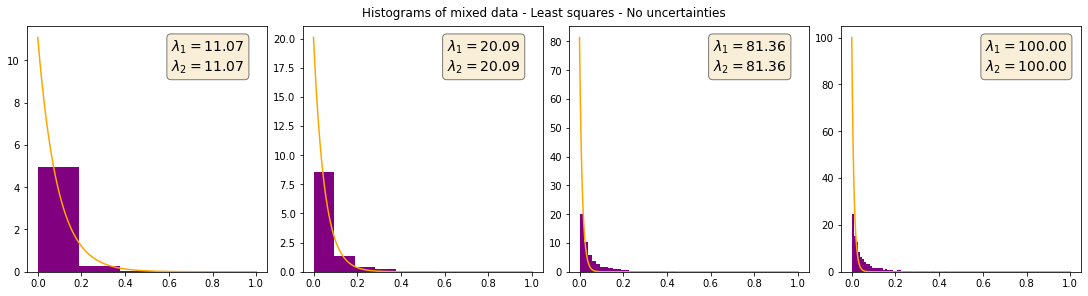

In [153]:
def fitfunc(hist):
    hist_values = hist[0]; bin_edges = hist[1]
    i_nonzero = hist_values !=0 # You don't wanna take places into account where the histogram is 0
    yerr = [1 for i in range(len(hist_values[i_nonzero]))]
    result = scipy.optimize.least_squares(res, starting_values, args=(f,bin_edges[i_nonzero], hist_values[i_nonzero], yerr), bounds=(1,100))
    # dummyvar = compare_fit(x, f(x,result.x[0],result.x[1]), f"Least squares - No uncertainties - $\lambda_1 = {result.x[0]}, \lambda_2 = {result.x[1]}$")
    return [result.x[0], result.x[1]]
    
compare_fit(fitfunc, "Least squares - No uncertainties")


### With statistical error

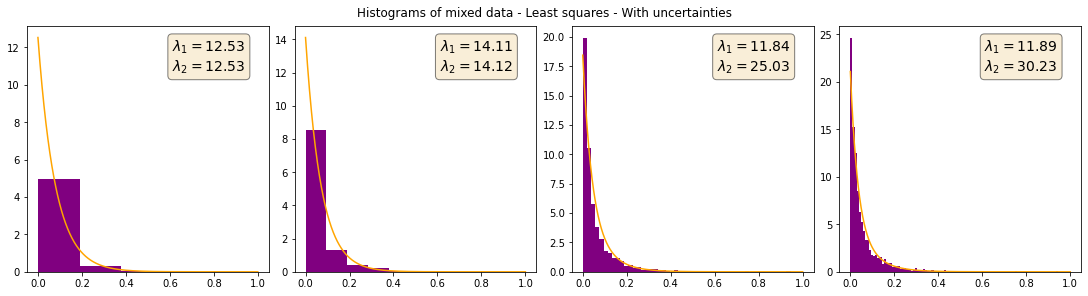

In [154]:
def fit_func(hist):
    hist_values = hist[0]; bin_edges = hist[1][0:-1]
    i_nonzero = hist_values !=0 # You don't wanna take places into account where the histogram is 0
    # Let's care about statistical uncertainties now.
    yerr = np.sqrt(hist_values[i_nonzero]) # The formula for chisquared now is (O-E)^2/E but the E (expected value) is squared in the formula we wrote so here we compensate for that.
    result = scipy.optimize.least_squares(res, (starting_values), args=(f,bin_edges[i_nonzero], hist_values[i_nonzero], yerr), bounds=(1,100))
    return [result.x[0], result.x[1]]

compare_fit(fit_func, f"Least squares - With uncertainties")

### With integration

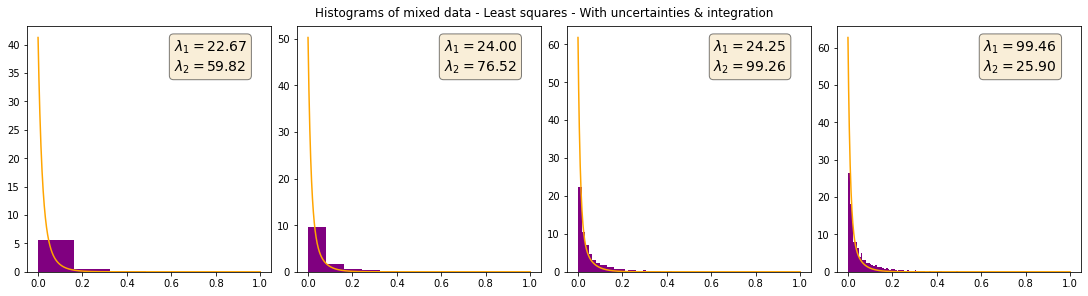

In [ ]:
# What's the difference? The argument "integration" is set to "True" in the residual function now.
def fit_func(hist):
    hist_values = hist[0]; bin_edges = hist[1][0:-1]
    i_nonzero = hist_values !=0 # You don't wanna take places into account where the histogram is 0
    yerr = np.sqrt(hist_values[i_nonzero]) # The formula for chisquared now is (O-E)^2/E but the E (expected value) is squared in the formula we wrote so here we compensate for that.
    result = scipy.optimize.least_squares(res, (starting_values), args=(f,bin_edges[i_nonzero], hist_values[i_nonzero], yerr, True), bounds=(1,100))
    return [result.x[0], result.x[1]]

compare_fit(fit_func, f"Least squares - With uncertainties & integration")

## Method of Maximum Likelyhood

C:\Users\Julian\AppData\Local\Temp\ipykernel_17448\260836250.py:69: RuntimeWarning: invalid value encountered in log
  return -np.sum(histogram * np.log(probability_per_bin(pdf, bin_list, parameters)))
C:\Users\Julian\AppData\Local\Temp\ipykernel_17448\260836250.py:24: RuntimeWarning: overflow encountered in exp
  return (lambda1*np.exp(-lambda1*x)+lambda2*np.exp(-lambda2*x))/2
C:\Users\Julian\AppData\Local\Temp\ipykernel_17448\260836250.py:24: RuntimeWarning: overflow encountered in double_scalars
  return (lambda1*np.exp(-lambda1*x)+lambda2*np.exp(-lambda2*x))/2
C:\Users\Julian\AppData\Local\Temp\ipykernel_17448\260836250.py:69: RuntimeWarning: invalid value encountered in log
  return -np.sum(histogram * np.log(probability_per_bin(pdf, bin_list, parameters)))
C:\Users\Julian\AppData\Local\Temp\ipykernel_17448\260836250.py:24: RuntimeWarning: overflow encountered in exp
  return (lambda1*np.exp(-lambda1*x)+lambda2*np.exp(-lambda2*x))/2
C:\Users\Julian\AppData\Local\Temp\ipykernel_174

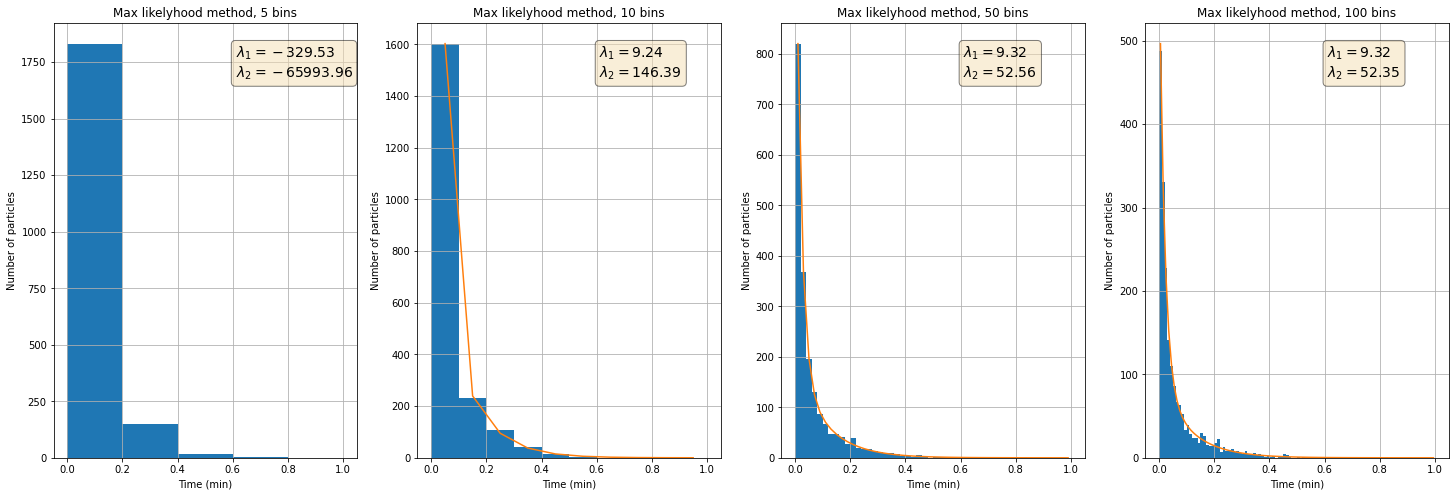

In [ ]:
%matplotlib inline   

#Lists for the histogram's bins and the number of edges
hist_list, bin_list = zip(*[np.histogram(s, i, [0, 1]) for i in bins])

#Our formula itself used for calculatinf the probabilities per bin
def exponential_formula(x, theta):
  """
    Returns the modified probabilty density function (pdf) for the
    exponential distribution adapted to fit the data (scaled)
    
    Input parameters:
        x -- argument for which the PDF will be evaluated
        theta[0] -- parameter lambda1 of the exponential PDF
        theta[1] -- parameter lambda2 of the exponential PDF
    
    Output parameters:
        return -- the formula itself used in this problem
    
    """
  lambda1 = theta[0]
  lambda2 = theta[1]

  return (lambda1*np.exp(-lambda1*x)+lambda2*np.exp(-lambda2*x))/2

# Define which calculates probabilities per bin
def probability_per_bin(pdf_fcn,edges,params):
    """
    By this function the probability for each bin is calculated given the number of edges,
    the function used itself and the parameters (lambda1 and lambda2)
    
    Input parameters:
        pdf_fcn -- input pdf function
        edges   -- array with bin edges
        params  -- the PDF parameters

    Output parameters:
        probabilities -- array of probabilities for each bin
    
    """
    def func(x):
        """ 
        Function for evaluatin the integral
        """
        return pdf_fcn(x,params)
    
    probabilities = np.empty(0)                      # create empy array for output values
    for u,v in np.nditer([edges[:-1],edges[1:]]):   # loop over all bins
        prob, error = integrate.quad(func,u,v)      # perform integration of the PDF, returning the probability (solution) and the error
        probabilities = np.append(probabilities,prob)  # store the result
    return probabilities

def minus_loglikelyhood(parameters, pdf, histogram, bin_list):
    '''
    Via this function we can compute the probability of obtaining a particular histogram given the parameters of 
    a probability density function. The result is the product of the probabability of each bin. As we want to maximize the result, 
    we put a negative sign before the returned result so it can be minimazed. In this way, by computing the logarithm of the result
    and minimazing its negative we will obtain the lambdas.

    Input parameters:
        parameters -- parameters to passed to the pdf, in this case lambda1 and lambda2
        pdf -- the function used
        histogram -- number of observed entries in each bin
        bin_list -- edges of the bins of the histogram
    
    Output peturns:
        return -- -sum(log(likelyhood of each bin))
    '''
    return -np.sum(histogram * np.log(probability_per_bin(pdf, bin_list, parameters)))

def maximize_likelyhood_final_result(hist_list, bin_list, starting_parameters=[10, 50]):
    '''
    Given a histogram, this function try to estimate the parameters of the double exponential distribution maximizing the likelyhood
    of randomly obtaining this particular histogram. The method of integration of the pdf over the bins and the treatment of uncertainties
    are the same of the function residuals_sum.

    Input parameters:
        hist_list -- list of histograms
        bin_list -- list of bin edges of the histogram
        starting_parameters -- the given parameters to initialize the programm

    Output parameters:
        return -- plotting of the fits with their respective lambdas
    '''       
    #Creating a figure for the plots:                        
    fig = plt.figure(figsize=(25,8))
    N = len(hist_list)                            # number of histograms
    axs = fig.subplots(1, N)

    #Going over all the cases for different nubmer of bins:
    for hist, bin_list, ax in zip(hist_list, bin_list, axs):
        # if the histogram has more than 10 bins the integration take too much time, without relevant improvements in fit quality

        #Minimizing the sumation taken from minus_loglikelyhood 
        max_likelyhood = sp.optimize.minimize(minus_loglikelyhood, starting_parameters, args=((exponential_formula, hist, bin_list)))
        
        #Substracting its results
        fit_parameters = max_likelyhood.x
        bin_centers = 0.5 * (bin_list[1:] + bin_list[:-1])

        #plotting the maximum likelihood methos in the histograms:
        ax.hist(bin_list[0:-1], bin_list, weights=hist)
        ax.plot(bin_centers, 2000 * probability_per_bin(exponential_formula, bin_list, fit_parameters))
        ax.set_title("Max likelyhood method, {} bins".format(len(bin_list)-1))
        ax.grid(True)
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Number of particles')

        # create a text box with the value of lambda1 and lambda2
        textstr = '\n'.join((
        r'$\lambda_1=%.2f$' % (fit_parameters[0], ),
        r'$\lambda_2=%.2f$' % (fit_parameters[1], )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
#Finally the results are plot for random data:
maximize_likelyhood_final_result(hist_list, bin_list, [10, 50])

1)Method of moments:

2)Method of least squares without statistical error:

3)Method of least squares with statistical error: 

4)Method of least squares with integration:

5)Maximum likelyhood method: In this method as we are using an iterating function (scipy.optimize.minimize), sometimes for little number of bins (5 and 10) we might obtain good values for the lambdas but other times they can be completely nonsense. On the other hand, for bins=50 and bins=100 the values of the lambdas are neraly always near the actual values of the lambdas (10 and 50).